<h1 style="font-size:40px;"><center>Exercise V:<br> GANs
</center></h1>

## Short summary
In this exercise, we will design a generative network to generate the last rgb image given the first image. These folder has **three files**: 
- **configGAN.py:** this involves definitions of all parameters and data paths
- **utilsGAN.py:** includes utility functions required to grab and visualize data 
- **runGAN.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a network model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution | 
| 5 | Data | Needed | Generating the data batches |
| 6 | Debug | Needed | Debugging the data |
| 7 | Device | Needed | Selecting CPU/GPU |
| 8 | Init | Needed | Sets up the timer and other neccessary components |
| 9 | Training | Exercise 1-2 | Training the model   |
| 10 | Testing | Exercise 1-2| Testing the  method   |  


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and continuing with the next cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report

There is no need to provide any report. However, implemented network architecuture and observed experimental results must be presented as a short presentation in the last lecture, May 28.

1) We first start with importing all required modules

In [1]:
def limit_gpu():
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
limit_gpu()

"\ndef limit_gpu():\n    import tensorflow as tf\n    gpus = tf.config.experimental.list_physical_devices('GPU')\n    if gpus:\n        try:\n            for gpu in gpus:\n                tf.config.experimental.set_memory_growth(gpu, True)\n        except RuntimeError as e:\n            print(e)\nlimit_gpu()\n"

In [2]:
import os
from configGAN import *
cfg = flying_objects_config()
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
from tensorflow import keras
from utilsGAN import *
from sklearn.metrics import confusion_matrix
# import seaborn as sns
from datetime import datetime
import imageio
from skimage import img_as_ubyte

import pprint
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, LeakyReLU
import keras.backend as kb


creating network model using gpu 0


In [3]:
#%load_ext tensorboard
print(tf.__version__)
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

2.3.0
/home/stud/f/fremar16/miniconda3/envs/lab/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [4]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6128: logdir ./logs (started 21 days, 2:19:22 ago; pid 765998)
  - port 6128: logdir ./logs (started 27 days, 7:49:55 ago; pid 578020)
  - port 6010: logdir output_log_dir (started 2 days, 1:58:34 ago; pid 1503475)
  - port 6006: logdir ./logs (started 28 days, 5:34:59 ago; pid 501025)
  - port 6007: logdir logs/temp/ (started 2 days, 2:48:44 ago; pid 1482862)
  - port 6128: logdir ./logs (started 26 days, 11:28:50 ago; pid 584864)
  - port 6009: logdir output_log_dir (started 2 days, 2:06:58 ago; pid 1503235)
  - port 6006: logdir ./logs (started 2 days, 1:05:12 ago; pid 1509941)
  - port 6128: logdir ./logs (started 27 days, 2:27:49 ago; pid 580691)
  - port 6007: logdir ./logs/ (started 21 days, 6:13:54 ago; pid 762981)
  - port 6008: logdir logs/tensorboard/ (started 2 days, 2:46:58 ago; pid 1482929)
  - port 6128: logdir ./logs (started 28 days, 14:54:57 ago; pid 395176)


In [5]:
#!kill 501025

In [6]:
#notebook.display(port=6006, height=1000)
#notebook.start()

2) Here, we have the network model class definition. In this class, the most important functions are **build_generator()** and **build_discriminator()**. As defined in the exercises section, your task is to update the both network architectures defined in these functions.

In [7]:
class GANModel():
    def __init__(self, batch_size=32, inputShape=(64, 64, 3), dropout_prob=0.25): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

        # Calculate the shape of patches
        patch = int(self.inputShape[0] / 2**4)
        self.disc_patch = (patch, patch, 1)
  
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=Adam(0.0002, 0.5),metrics='accuracy')
 
        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        first_frame = Input(shape=self.inputShape)
        last_frame = Input(shape=self.inputShape)

        # By conditioning on the first frame generate a fake version of the last frame
        fake_last_frame = self.generator(first_frame)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # Discriminators determines validity of fake and condition first image pairs
        valid = self.discriminator([fake_last_frame, first_frame])

        self.combined = Model(inputs=[last_frame, first_frame], outputs=[valid, fake_last_frame])
        self.combined.compile(loss=['mse', 'mae'], # mean squared and mean absolute errors
                              loss_weights=[1, 100],
                              optimizer=Adam(0.0002, 0.5),
                              metrics='accuracy')

    def build_generator(self):
 
        inputs = Input(shape=self.inputShape)
        print(inputs.shape)
 
        down1 = Conv2D(32, (3, 3),padding='same')(inputs)
        down1 = Activation('relu')(down1) 
        down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
         
        down2 = Conv2D(64, (3, 3), padding='same')(down1_pool)
        down2 = Activation('relu')(down2) 
         

        up1 = UpSampling2D((2, 2))(down2)
        up1 = concatenate([down1, up1], axis=3)
        up1 = Conv2D(256, (3, 3), padding='same')(up1) 
        up1 = Activation('relu')(up1) 
        
        
        up2 = Conv2D(256, (3, 3), padding='same')(up1) 
        up2 = Activation('relu')(up2) 
        
        nbr_img_channels = self.inputShape[2]
        outputs = Conv2D(nbr_img_channels, (1, 1), activation='sigmoid')(up2)

        model = Model(inputs=inputs, outputs=outputs, name='Generator')
        model.summary()

        return model

    def build_discriminator(self):
  
        last_img = Input(shape=self.inputShape)
        first_img = Input(shape=self.inputShape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([last_img, first_img])
        
        d1 = Conv2D(32, (3, 3), strides=2, padding='same')(combined_imgs) 
        d1 = Activation('relu')(d1) 
        d2 = Conv2D(64, (3, 3), strides=2, padding='same')(d1)
        d2 = Activation('relu')(d2) 
        d3 = Conv2D(128, (3, 3), strides=2, padding='same')(d2)
        d3 = Activation('relu')(d3) 
         
        validity = Conv2D(1, (3, 3), strides=2, padding='same')(d3)

        model = Model([last_img, first_img], validity)
        model.summary()

        return model

3) We import the network **hyperparameters** and build a simple network by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configPredictor.py.**

In [8]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = GANModel(batch_size=cfg.BATCH_SIZE, inputShape=image_shape,
                                 dropout_prob=cfg.DROPOUT_PROB)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 64, 6)    0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   1760        concatenate[0][0]     

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [9]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=False, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=False, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=False, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class circular 	 3626 images
class triangle 	 3703 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class square 	 783 images
class circular 	 713 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [10]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_lastframepredictor_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_lastframepredictor_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_lastframepredictor_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
print("Data batch generators are created!")

Data batch generators are created!


6) We can visualize how the data looks like for debugging purpose

In [11]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('train_x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('train_y', t_y.shape, t_y.dtype, t_y.min(), t_y.max()) 
    #plot_sample_lastframepredictor_data_with_groundtruth(t_x, t_y, t_y)
    pprint.pprint (cfg)

train_x (30, 64, 64, 3) float32 0.0 1.0
train_y (30, 64, 64, 3) float32 0.0 1.0
{'BATCH_SIZE': 30,
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 64,
 'IMAGE_WIDTH': 64,
 'LEARNING_RATE': 0.01,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_EPOCHS': 10,
 'PRINT_EVERY': 50,
 'SAVE_EVERY': 1,
 'SEQUENCE_LENGTH': 10,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


7) Start timer and init matrices

In [12]:
start_time = datetime.now()
# Adversarial loss ground truths
valid = np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)
fake = np.zeros((cfg.BATCH_SIZE,) + modelObj.disc_patch)
# log file


In [13]:
# SETUP loggers
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(output_log_dir):
    os.makedirs(output_log_dir)
    
train_log_dir = output_log_dir + '/train'
test_log_dir = output_log_dir + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [41]:
import matplotlib.pyplot as plt
def do_plot(content, ylabel="Loss",title='Model', save_dir=None):
    plt.plot(content)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    if save_dir:
        plt.savefig(save_dir)
    plt.show()

def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    plt.figure(figsize=(6,8))
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    plt.savefig(output_log_dir+ '/plot_line_plot_loss.png')
    plt.show()
    plt.close()


8) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configGAN.py.**

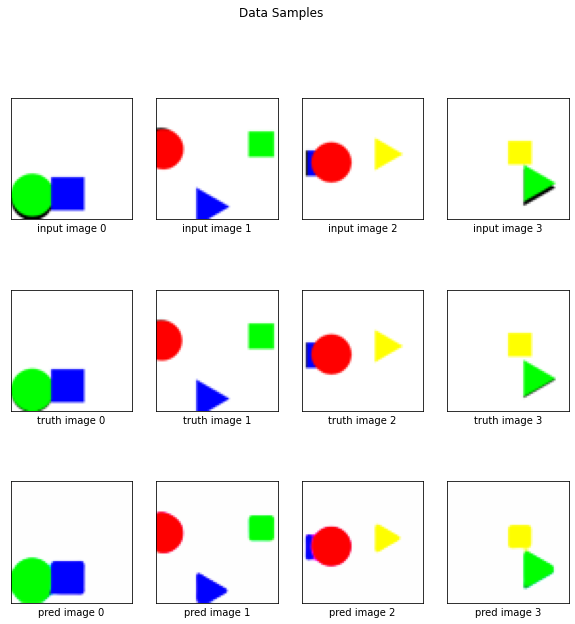

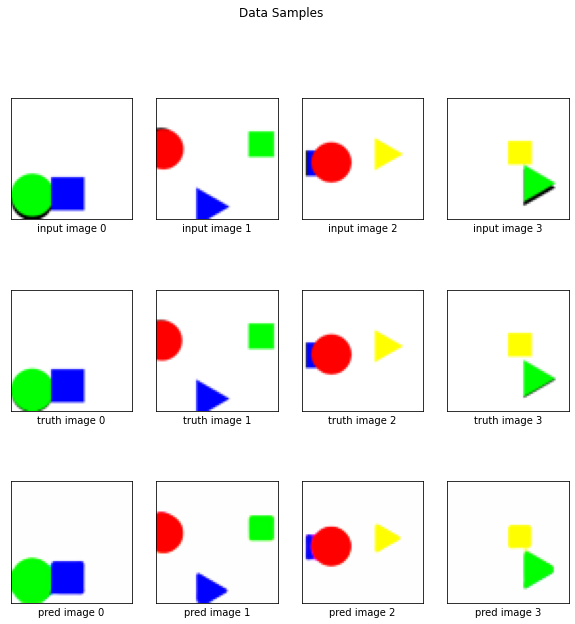

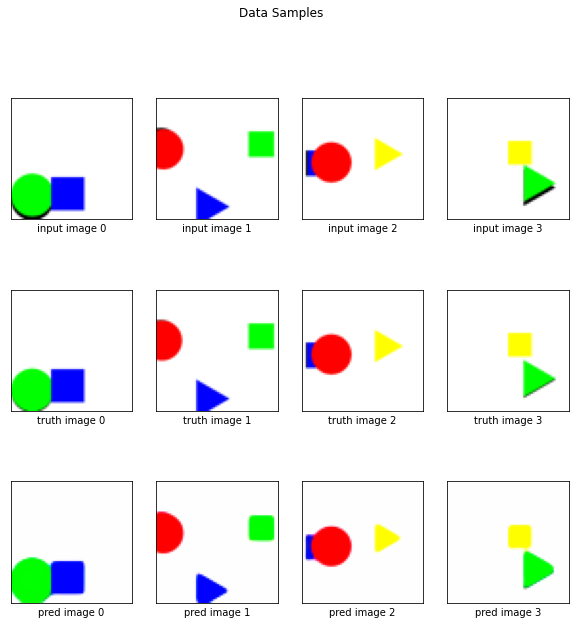

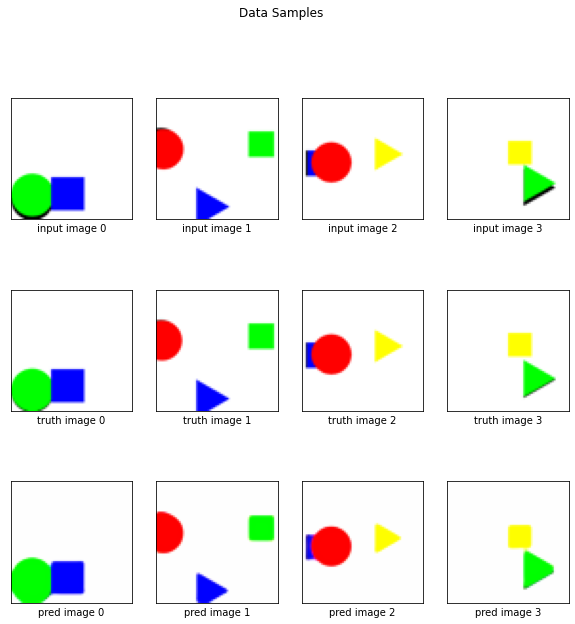

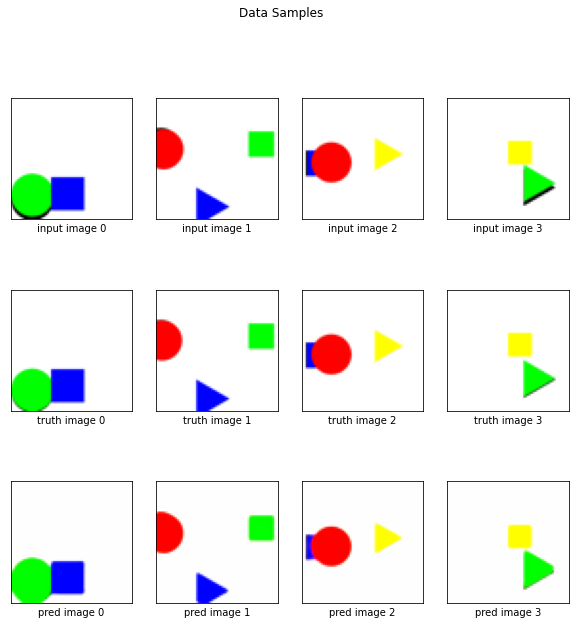

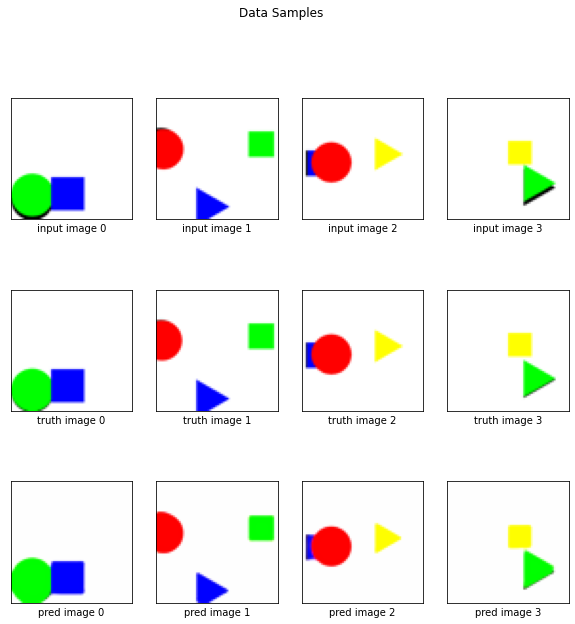

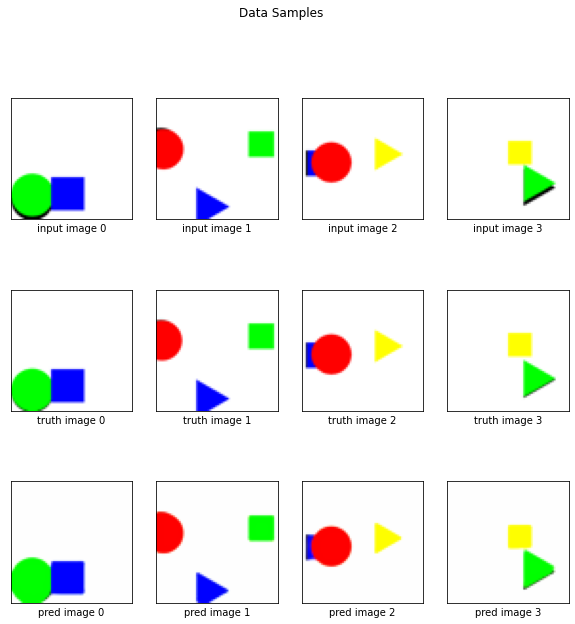

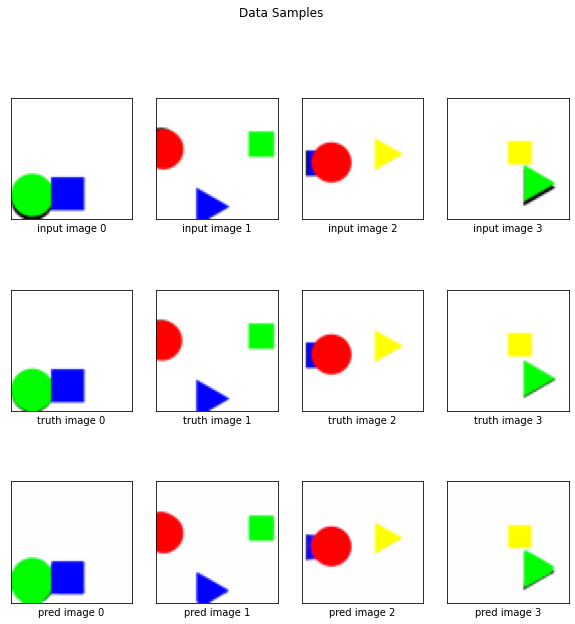

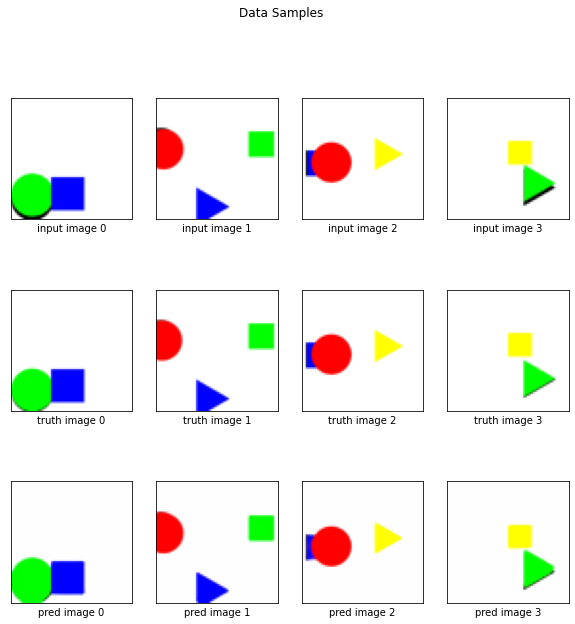

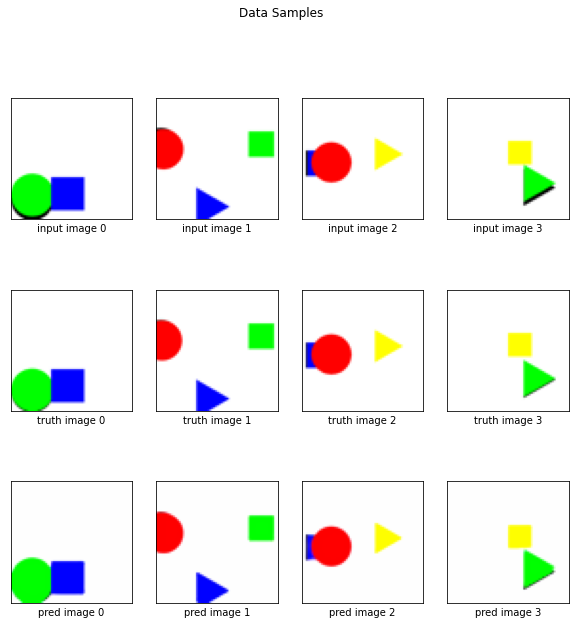

In [17]:
test_first_imgs, test_last_imgs = next(test_batch_generator)
d_real_loss = d_fake_loss = []
d_real_acc = d_fake_acc =[]
g_eval_loss = []
def calculate_mean(val1, val2):
    return 0.5 * np.add(val1, val2)
for epoch in range(cfg.NUM_EPOCHS):
    steps_per_epoch = (nbr_train_data // cfg.BATCH_SIZE) 
    for batch_i in range(steps_per_epoch):
        first_frames, last_frames= next(train_batch_generator)
        if first_frames.shape[0] == cfg.BATCH_SIZE: 
             
            # Condition on the first frame and generate the last frame
            fake_last_frames = modelObj.generator.predict(first_frames)

            # Train the discriminator with combined loss  
            d_metric_real = modelObj.discriminator.train_on_batch([last_frames, first_frames], valid, return_dict=True) #, return_dict=True
            d_metric_fake = modelObj.discriminator.train_on_batch([fake_last_frames, first_frames], fake, return_dict=True)
            
            # Calculate mean loss value
            d_loss = calculate_mean(d_metric_real['loss'], d_metric_fake['loss'])
            d_acc = calculate_mean(d_metric_real['accuracy'], d_metric_fake['accuracy'])
            # Train the generator
            g_metric = modelObj.combined.train_on_batch([last_frames, first_frames], [valid, last_frames], return_dict=True)
            g_loss = g_metric['loss']
            elapsed_time = datetime.now() - start_time 

            print('[Epoch %d/%d] \t [Batch %d/%d] \t [D loss: %f] \t [G loss: %f] \t time: %s' % (
                epoch+1,
                cfg.NUM_EPOCHS,
                batch_i+1,
                steps_per_epoch,
                d_loss, 
                g_loss,
                elapsed_time
            ),end='\r')
    d_real_loss.append(d_metric_real['loss'])
    d_fake_loss.append(d_metric_fake['loss'])
    d_real_acc.append(d_metric_real['accuracy'])
    d_fake_acc.append(d_metric_fake['accuracy'])
    g_eval_loss.append(g_metric['loss'])
  
    # run some tests to check how the generated images evolve during training
    test_fake_last_imgs = modelObj.generator.predict(test_first_imgs)
    test_img_name = output_log_dir + "/gen_img_epoc_" + str(epoch) + ".png"
    merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    #imageio.imwrite(test_img_name, img_as_ubyte(merged_img))
    plot_sample_lastframepredictor_data_with_groundtruth(test_first_imgs, test_last_imgs, test_fake_last_imgs, show=False).savefig(test_img_name)


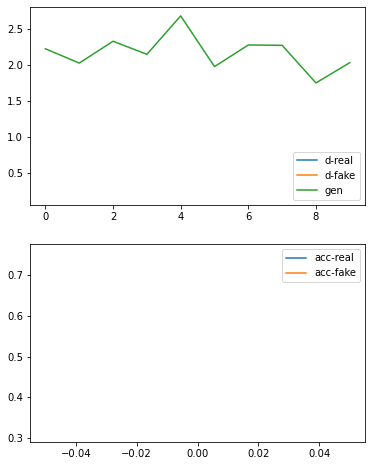

In [42]:
plot_history(d_real_loss, d_fake_loss, g_eval_loss, d_real_acc, d_fake_acc)

In [ ]:
plot_sample_lastframepredictor_data_with_groundtruth(test_first_imgs, test_last_imgs, test_fake_last_imgs, batch_size=5)

import fid9) We can test the model with 100 test data which will be saved as images

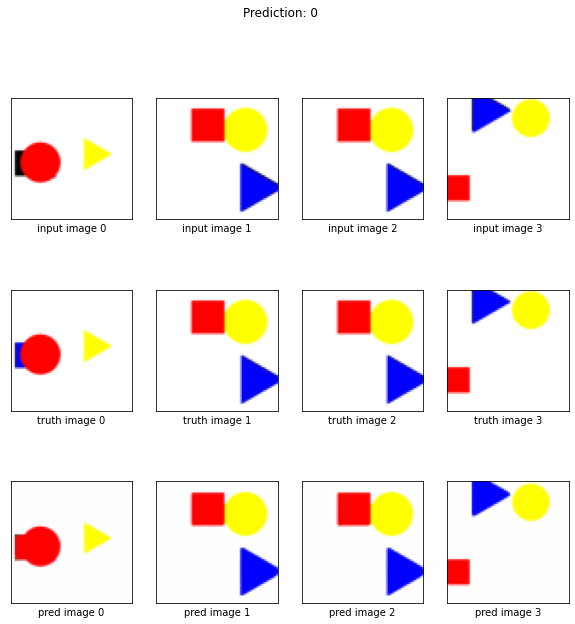

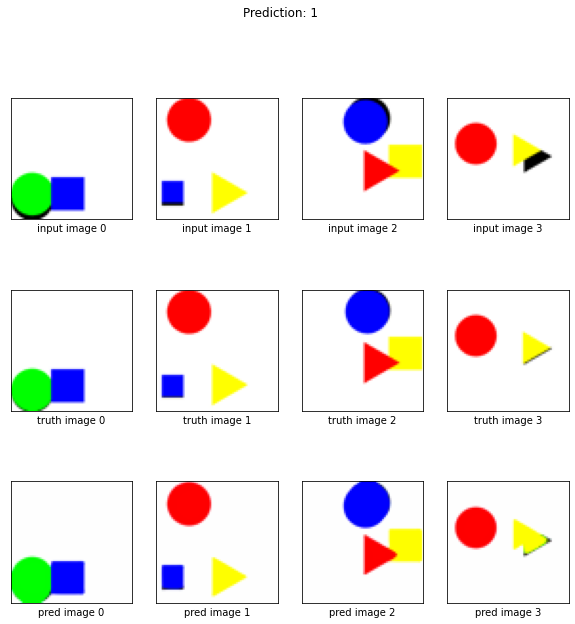

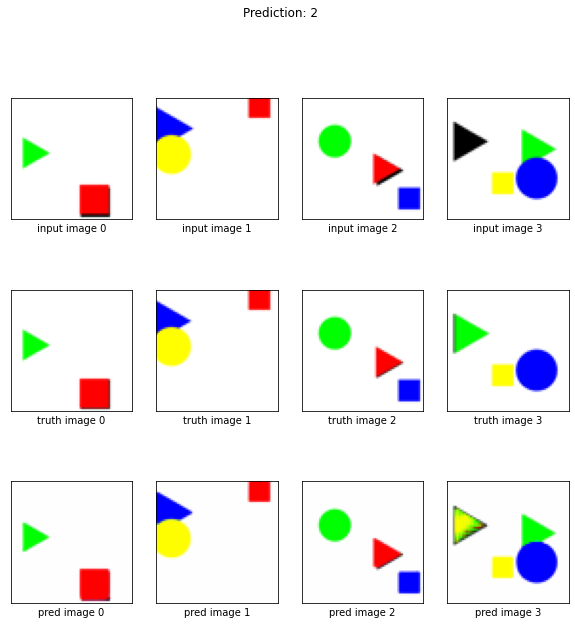

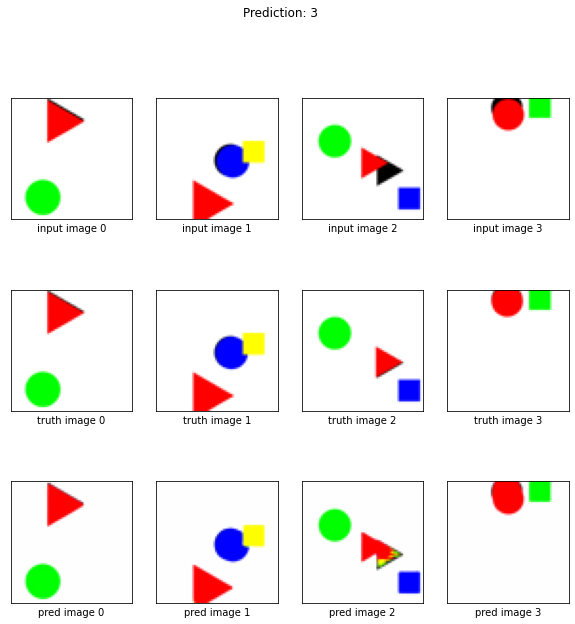

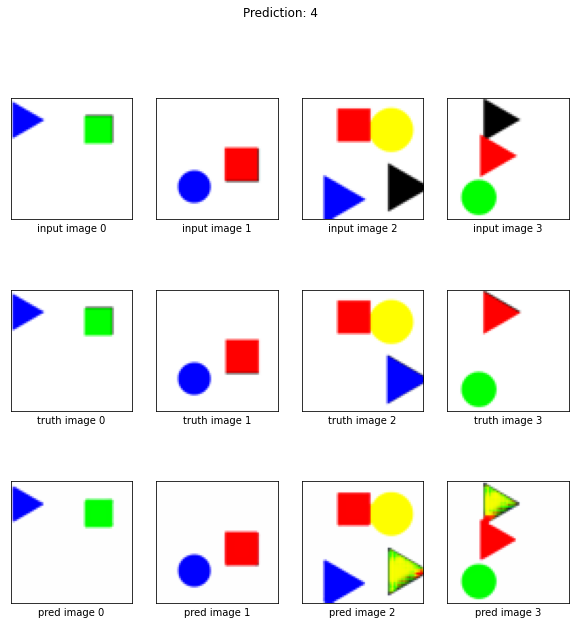

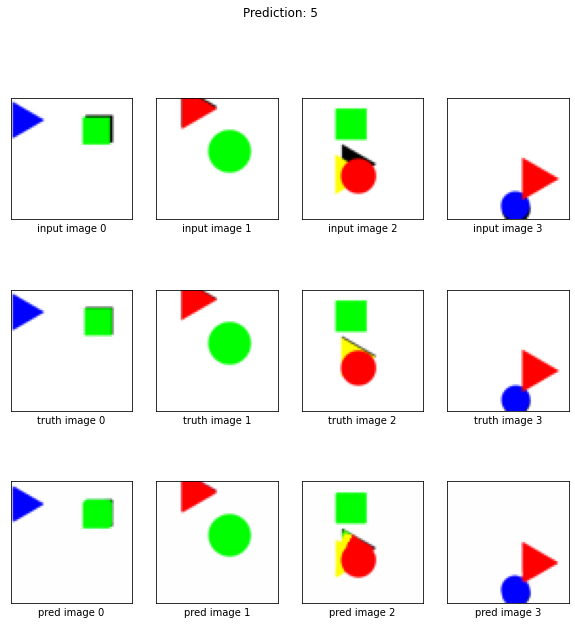

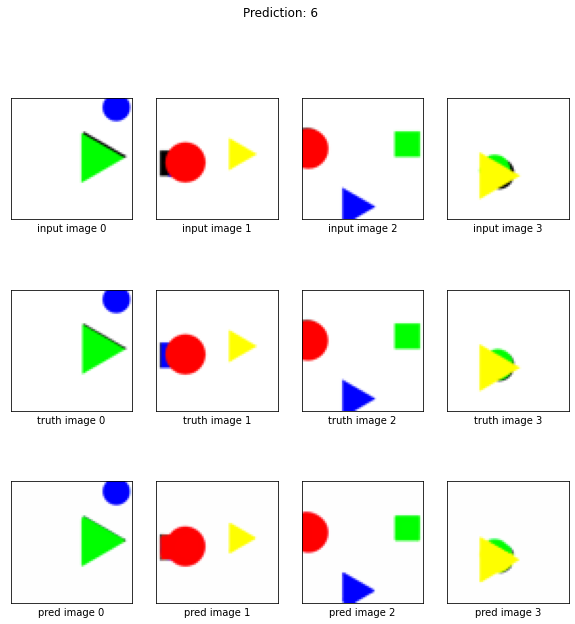

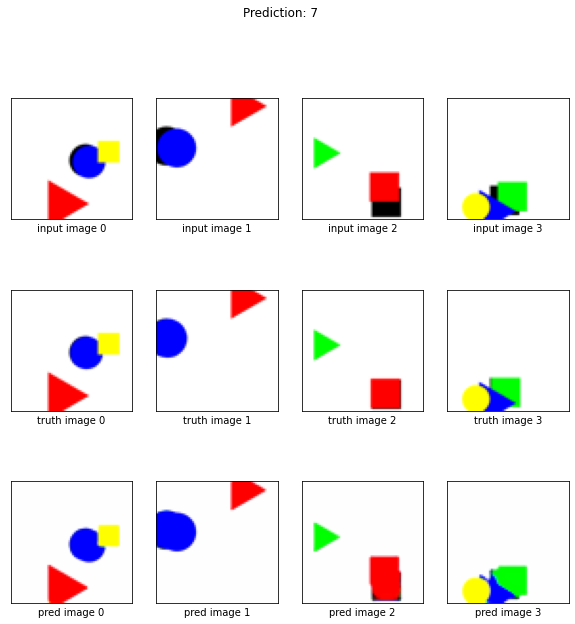

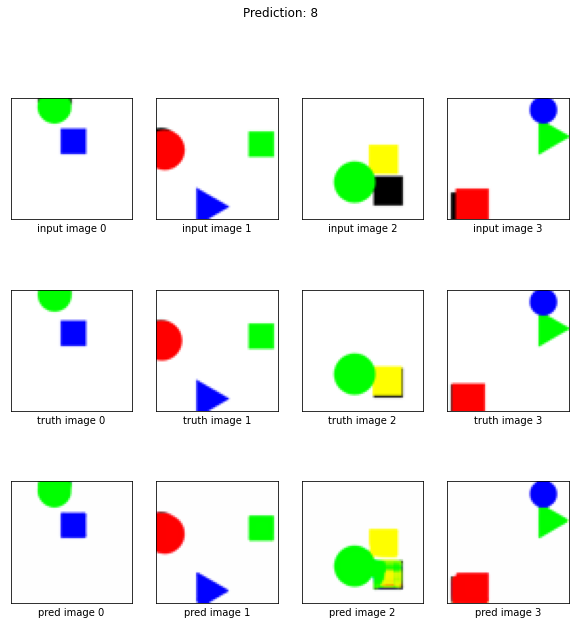

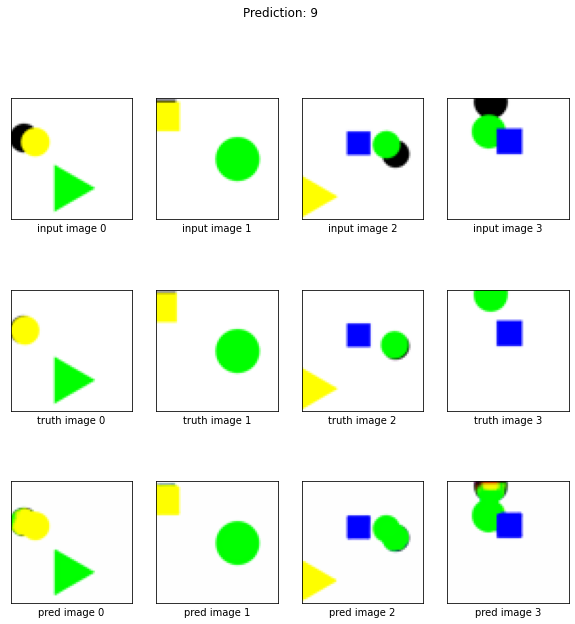

In [34]:
for batch_i in range(10):
    test_first_imgs, test_last_imgs = next(test_batch_generator)
    test_fake_last_imgs = modelObj.generator.predict(test_first_imgs) 

    test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    #imageio.imwrite(test_img_name, img_as_ubyte(merged_img))
    plot_sample_lastframepredictor_data_with_groundtruth(test_first_imgs, test_last_imgs, test_fake_last_imgs, show=False, title=f'Prediction: {batch_i}').savefig(test_img_name)

## EXERCISES

#### Exercise 1)
Update the network architecture given in  **build_generator**  and  **build_discriminator**  of the class GANModel. Please note that the current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT values) in the file configGAN.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. data augmentation, dropout) methods to increase the network accuracy. 